In [1]:
%matplotlib inline


# Selecting dimensionality reduction with Pipeline and GridSearchCV


This example constructs a pipeline that does dimensionality
reduction followed by prediction with a support vector
classifier. It demonstrates the use of ``GridSearchCV`` and
``Pipeline`` to optimize over different classes of estimators in a
single CV run -- unsupervised ``PCA`` and ``NMF`` dimensionality
reductions are compared to univariate feature selection during
the grid search.

Additionally, ``Pipeline`` can be instantiated with the ``memory``
argument to memoize the transformers within the pipeline, avoiding to fit
again the same transformers over and over.

Note that the use of ``memory`` to enable caching becomes interesting when the
fitting of a transformer is costly.



Illustration of ``Pipeline`` and ``GridSearchCV``
##############################################################################
 This section illustrates the use of a ``Pipeline`` with
 ``GridSearchCV``



### Import Libraries

In [2]:
# Authors: Robert McGibbon, Joel Nothman, Guillaume Lemaitre

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from IPython.display import HTML
from time import time

print(__doc__)

Automatically created module for IPython interactive environment


### Turn off Notebook Warnings

The javascript/html snippet below will hide those pesky red warning boxes that appear in output.

In [3]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

### Build pipeline

In [4]:
pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

### Set `PCA` Parameters, `SVC` Parameters, and `GridSearchCV` Parameters

In [5]:
N_FEATURES_OPTIONS = [2, 4, 8, 16, 32, 64]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

### Init `GridSearchCV` Object

In [6]:
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)

### Load data

In [7]:
digits = load_digits()

### Fit `GridSearchCV` Using `Pipeline`

In [8]:
start = time()
grid.fit(digits.data, digits.target)
end = time()
runtime = end - start
print('grid took {} minutes to run to completion.'.format(runtime/60))
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear f

grid took 1.4941226363182067 minutes to run to completion.


### Check Accuracy

In [9]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores

array([0.48692265, 0.72621035, 0.83249861, 0.89705064, 0.91875348,
       0.90261547, 0.32109071, 0.65831942, 0.82025598, 0.91318865,
       0.92264886, 0.90094602, 0.40289371, 0.56538676, 0.79131886,
       0.88814691, 0.90261547, 0.9015025 , 0.32665554, 0.65831942,
       0.82804674, 0.91374513, 0.91652755, 0.89315526, 0.23149694,
       0.47801892, 0.7345576 , 0.88647746, 0.89927657, 0.89816361,
       0.29271007, 0.65831942, 0.81357819, 0.90706733, 0.91207568,
       0.89816361, 0.26377295, 0.4885921 , 0.75792988, 0.88814691,
       0.91318865, 0.89204229, 0.1736227 , 0.47468002, 0.7506956 ,
       0.88035615, 0.89816361, 0.8853645 , 0.30884808, 0.46744574,
       0.67890929, 0.8196995 , 0.89649416, 0.89037284, 0.2031163 ,
       0.34168058, 0.57595993, 0.78797997, 0.9081803 , 0.90038954,
       0.25542571, 0.27045075, 0.44017807, 0.8130217 , 0.88592098,
       0.89983306, 0.14468559, 0.22481914, 0.57595993, 0.78464107,
       0.90372844, 0.9015025 ])

### Reshape scores array based on `GridSearchCV` parameters

In [10]:
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
mean_scores

array([[[0.48692265, 0.72621035, 0.83249861, 0.89705064, 0.91875348,
         0.90261547],
        [0.32109071, 0.65831942, 0.82025598, 0.91318865, 0.92264886,
         0.90094602],
        [0.40289371, 0.56538676, 0.79131886, 0.88814691, 0.90261547,
         0.9015025 ]],

       [[0.32665554, 0.65831942, 0.82804674, 0.91374513, 0.91652755,
         0.89315526],
        [0.23149694, 0.47801892, 0.7345576 , 0.88647746, 0.89927657,
         0.89816361],
        [0.29271007, 0.65831942, 0.81357819, 0.90706733, 0.91207568,
         0.89816361]],

       [[0.26377295, 0.4885921 , 0.75792988, 0.88814691, 0.91318865,
         0.89204229],
        [0.1736227 , 0.47468002, 0.7506956 , 0.88035615, 0.89816361,
         0.8853645 ],
        [0.30884808, 0.46744574, 0.67890929, 0.8196995 , 0.89649416,
         0.89037284]],

       [[0.2031163 , 0.34168058, 0.57595993, 0.78797997, 0.9081803 ,
         0.90038954],
        [0.25542571, 0.27045075, 0.44017807, 0.8130217 , 0.88592098,
         0.8998

### Display best score based on `GridSearchCV`

In [11]:
# select score for best C
mean_scores = mean_scores.max(axis=0)
mean_scores

array([[0.48692265, 0.72621035, 0.83249861, 0.91374513, 0.91875348,
        0.90261547],
       [0.32109071, 0.65831942, 0.82025598, 0.91318865, 0.92264886,
        0.90094602],
       [0.40289371, 0.65831942, 0.81357819, 0.90706733, 0.91207568,
        0.9015025 ]])

### Utility to make graph pretty

In [12]:
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)
bar_offsets

array([ 0.5,  4.5,  8.5, 12.5, 16.5, 20.5])

### Plot results

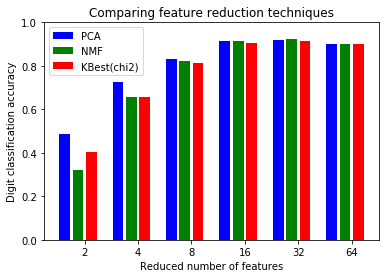

In [13]:
plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

# Caching transformers within a ``Pipeline``
##############################################################################
 It is sometimes worthwhile storing the state of a specific transformer
 since it could be used again. Using a pipeline in ``GridSearchCV`` triggers
 such situations. Therefore, we use the argument ``memory`` to enable caching.



### Create a temporary folder to store the transformers of the pipeline

In [14]:
cachedir = mkdtemp()

### Init `sklearn.externals.joblib.Memory` Object

A context object for caching a function's return value each time it
is called with the same input arguments.

All values are cached on the filesystem, in a deep directory
structure.

In [15]:
memory = Memory(cachedir=cachedir, verbose=10)
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

/Users/travisjefferies/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs'", use "location='/var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs'" instead.
  if __name__ == '__main__':


### Build pipeline

This time we will specify the `memory` parameter using the `sklearn.externals.joblib.Memory` object we created above.

In [16]:
cached_pipe = Pipeline([('reduce_dim', PCA()),
                        ('classify', LinearSVC())],
                       memory=memory)

### Init `GridSearchCV` Object

This time, a cached pipeline will be used within the grid search

In [17]:
grid = GridSearchCV(cached_pipe, cv=3, n_jobs=1, param_grid=param_grid)

### Fit `GridSearchCV` Using Cached `Pipeline`

The ``PCA`` fitting is only computed at the evaluation of the first
configuration of the ``C`` parameter of the ``LinearSVC`` classifier. The
other configurations of ``C`` will trigger the loading of the cached ``PCA``
estimator data, leading to save processing time. Therefore, the use of
caching the pipeline using ``memory`` is highly beneficial when fitting
a transformer is costly.



In [18]:
start2 = time()
grid.fit(digits.data, digits.target)
end2 = time()
runtime2 = end2 - start2
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_

/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=2, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=2, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
____________________

/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=64, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 1.2s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=64, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 2.5s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/88257ac094590decabacfe453cac5a66
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/fc90994064d6f8b0d70cb94359a4d6a8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/f91c6824e156c03769441820ced340cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/96917e6bdc9952e332e82fc265a8411d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/2932d21863708a786c3b48ec8f9cd9a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7de2b15ce76d3b03af397c7d889f8830
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/1ca9e8cebd614f28fa8e30f55a89f44f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/87bc9db9074a443ad9d115372c55c9a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/1f293a8d38fd0c7e609638367ac9fc99
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/0063477d11f719b408e9b6dd4b1c04bb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7d5bbc1a61647a358d5a67c662bbd72f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/3a9c9e195b15ec4cf48bed2b48740b1b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/6cffa934c3f90006d028a984ac687830
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/20a448e5c91c29352bb00be3183340ee
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/49876487a207cf7c6f63d565b092a65b


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/594c7bec37538969beb67d42027c9df2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7eed1fa6af3d4e2963beed0bb8c370cd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/0db25c192292915ca628cf59abc2cf9c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/0b320690cafec4d6c07f3afaafdfd1be
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7c42ac162969caedd89b2dde00ad0f49
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d4b3710685ee8bd385d5c2665b265f63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/ecf6f6fe73652c638f4cdd214d9d12e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/23c68b21cd9ed4eff16f113e725018ab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/f5c4a7b99bfc3838f92f2d06dd2b6f12
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d84763484b7bdce345765191ff484bca
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/41acba88dcc0f3cc3388ca0b472ff7c2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/e3089f424e930d7b1ba748f6ec9195d5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7e6835e54d985b61ec6cde527de2135c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/e3ab008aec2956fdcdda0877f9ae0f9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/67a110524c285c0038b548009aa1ada6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/89a037618ccd4e58a8c579531b6a7eb9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/ad427c6a60dd1ec0c6385b8fde4a0c6b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/a807cfd0fdad526833584b966bd3211d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d5a39bb00b2e2ae289ba3c82fd1b853a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/b2bbdfd9defc4eace97ef6fd35356c55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/b494b10f5358e107cb1109a032f20e4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/88257ac094590decabacfe453cac5a66
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/fc90994064d6f8b0d70cb94359a4d6a8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/f91c6824e156c03769441820ced340cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/96917e6bdc9952e332e82fc265a8411d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/2932d21863708a786c3b48ec8f9cd9a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7de2b15ce76d3b03af397c7d889f8830
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/1ca9e8cebd614f28fa8e30f55a89f44f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/87bc9db9074a443ad9d115372c55c9a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/1f293a8d38fd0c7e609638367ac9fc99
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/0063477d11f719b408e9b6dd4b1c04bb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7d5bbc1a61647a358d5a67c662bbd72f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/3a9c9e195b15ec4cf48bed2b48740b1b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/6cffa934c3f90006d028a984ac687830
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/20a448e5c91c29352bb00be3183340ee
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/49876487a207cf7c6f63d565b092a65b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/594c7bec37538969beb67d42027c9df2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7eed1fa6af3d4e2963beed0bb8c370cd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/0db25c192292915ca628cf59abc2cf9c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/0b320690cafec4d6c07f3afaafdfd1be
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7c42ac162969caedd89b2dde00ad0f49
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d4b3710685ee8bd385d5c2665b265f63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/ecf6f6fe73652c638f4cdd214d9d12e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/23c68b21cd9ed4eff16f113e725018ab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/f5c4a7b99bfc3838f92f2d06dd2b6f12
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d84763484b7bdce345765191ff484bca
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/41acba88dcc0f3cc3388ca0b472ff7c2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/e3089f424e930d7b1ba748f6ec9195d5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7e6835e54d985b61ec6cde527de2135c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/e3ab008aec2956fdcdda0877f9ae0f9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/67a110524c285c0038b548009aa1ada6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/89a037618ccd4e58a8c579531b6a7eb9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/ad427c6a60dd1ec0c6385b8fde4a0c6b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/a807cfd0fdad526833584b966bd3211d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d5a39bb00b2e2ae289ba3c82fd1b853a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/b2bbdfd9defc4eace97ef6fd35356c55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/b494b10f5358e107cb1109a032f20e4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/88257ac094590decabacfe453cac5a66
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/fc90994064d6f8b0d70cb94359a4d6a8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/f91c6824e156c03769441820ced340cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/96917e6bdc9952e332e82fc265a8411d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/2932d21863708a786c3b48ec8f9cd9a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7de2b15ce76d3b03af397c7d889f8830
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/1ca9e8cebd614f28fa8e30f55a89f44f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/87bc9db9074a443ad9d115372c55c9a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/1f293a8d38fd0c7e609638367ac9fc99
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/0063477d11f719b408e9b6dd4b1c04bb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7d5bbc1a61647a358d5a67c662bbd72f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/3a9c9e195b15ec4cf48bed2b48740b1b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/6cffa934c3f90006d028a984ac687830
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/20a448e5c91c29352bb00be3183340ee
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/49876487a207cf7c6f63d565b092a65b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/594c7bec37538969beb67d42027c9df2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7eed1fa6af3d4e2963beed0bb8c370cd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/0db25c192292915ca628cf59abc2cf9c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/0b320690cafec4d6c07f3afaafdfd1be
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7c42ac162969caedd89b2dde00ad0f49
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d4b3710685ee8bd385d5c2665b265f63
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/ecf6f6fe73652c638f4cdd214d9d12e1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/23c68b21cd9ed4eff16f113e725018ab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/f5c4a7b99bfc3838f92f2d06dd2b6f12
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d84763484b7bdce345765191ff484bca
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/41acba88dcc0f3cc3388ca0b472ff7c2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/e3089f424e930d7b1ba748f6ec9195d5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/7e6835e54d985b61ec6cde527de2135c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/e3ab008aec2956fdcdda0877f9ae0f9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/67a110524c285c0038b548009aa1ada6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/89a037618ccd4e58a8c579531b6a7eb9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/ad427c6a60dd1ec0c6385b8fde4a0c6b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/a807cfd0fdad526833584b966bd3211d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d5a39bb00b2e2ae289ba3c82fd1b853a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/b2bbdfd9defc4eace97ef6fd35356c55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/b494b10f5358e107cb1109a032f20e4c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=2, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=2, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=2, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=4, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=4, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=4, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=8, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=8, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=8, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=16, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=16, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=16, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=32, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=32, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=32, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 4]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=64, score_func=<function chi2 at 0x1a1a061ea0>), array([[0., .

/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


________________________________________________fit_transform_one - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d5995d5aa276242e8b2e40584d80291c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/4fff644cc4162efabeb1be32e68cdc7a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/2a0d18c5c3bde327059a9e98ad69efb0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/40fc8eab53aee0012abf144eec0952e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/1fa04505259ddf6024f358ce671a5a3b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/cc098c01a288074a4a715dec410432e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/c59088d9ed4b4ee24580bdbaf2c56c48
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/e43646055851a60b066f3982350f495c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d04dbd91bb4a7832eac8ceefd0324fae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/3e0c022ab64c2808aae7568d2007475d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/edaf0e6dab0a433c785dfa6906c9172c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/6c8f508cf1d39f9e2a2b0c0d771cf1b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/00e1523169a8b771488a96bf437d358e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/59e7b41f5d0778b52fac69ca483e5453
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/fc3468c8f9dd59ec86f017bb1cb7d2dc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/be06e46752d774fb2560cecb2bb2deab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/9874c9711d650b5b89de152c40c588a9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/b372b1ac4f2c528e9fc5bd8690f4cbcc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d5995d5aa276242e8b2e40584d80291c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/4fff644cc4162efabeb1be32e68cdc7a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/2a0d18c5c3bde327059a9e98ad69efb0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/40fc8eab53aee0012abf144eec0952e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/1fa04505259ddf6024f358ce671a5a3b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/cc098c01a288074a4a715dec410432e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/c59088d9ed4b4ee24580bdbaf2c56c48
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/e43646055851a60b066f3982350f495c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d04dbd91bb4a7832eac8ceefd0324fae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/3e0c022ab64c2808aae7568d2007475d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/edaf0e6dab0a433c785dfa6906c9172c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/6c8f508cf1d39f9e2a2b0c0d771cf1b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/00e1523169a8b771488a96bf437d358e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/59e7b41f5d0778b52fac69ca483e5453
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/fc3468c8f9dd59ec86f017bb1cb7d2dc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/be06e46752d774fb2560cecb2bb2deab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/9874c9711d650b5b89de152c40c588a9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/b372b1ac4f2c528e9fc5bd8690f4cbcc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d5995d5aa276242e8b2e40584d80291c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/4fff644cc4162efabeb1be32e68cdc7a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/2a0d18c5c3bde327059a9e98ad69efb0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/40fc8eab53aee0012abf144eec0952e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/1fa04505259ddf6024f358ce671a5a3b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/cc098c01a288074a4a715dec410432e4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/c59088d9ed4b4ee24580bdbaf2c56c48
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/e43646055851a60b066f3982350f495c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/d04dbd91bb4a7832eac8ceefd0324fae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/3e0c022ab64c2808aae7568d2007475d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/edaf0e6dab0a433c785dfa6906c9172c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/6c8f508cf1d39f9e2a2b0c0d771cf1b6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/00e1523169a8b771488a96bf437d358e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/59e7b41f5d0778b52fac69ca483e5453
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/fc3468c8f9dd59ec86f017bb1cb7d2dc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/be06e46752d774fb2560cecb2bb2deab
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/9874c9711d650b5b89de152c40c588a9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/cd/nwdgscbn3m7872qj56yv40rh0000gn/T/tmpyeup9cgs/joblib/sklearn/pipeline/_fit_transform_one/b372b1ac4f2c528e9fc5bd8690f4cbcc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=32, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), array([0, ..., 8]), None)
________________________________________________fit_transform_one - 1.0s, 0.0min


In [19]:
print('grid took {} minutes to run to completion.'.format(runtime2/60))

grid took 1.2737938682238261 minutes to run to completion.


Note the difference in run time below:

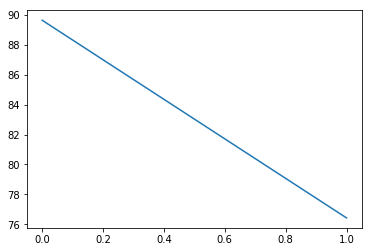

In [20]:
plt.plot([runtime, runtime2])

 .. warning::
     Note that this example is, however, only an illustration since for this
     specific case fitting PCA is not necessarily slower than loading the
     cache. Hence, use the ``memory`` constructor parameter when the fitting
     of a transformer is costly. Text transformations come to mind.

### Delete the temporary cache before exiting

Good practice.

In [21]:
rmtree(cachedir)

# Pipelining: chaining a PCA and a logistic regression

The PCA does an unsupervised dimensionality reduction, while the logistic regression does the prediction.

We use `GridSearchCV` to use data to set the dimensionality returned by `PCA`.

### Import Libraries

In [22]:
from sklearn import linear_model, decomposition, datasets

### Credit

In [23]:
print(__doc__)


# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

Automatically created module for IPython interactive environment


### Init `LogisticRegression` Object

In [24]:
logistic = linear_model.LogisticRegression()

### Init `PCA` Object

In [25]:
pca = PCA()

### Build pipeline

In [26]:
pipe = Pipeline(steps=
    [
        ('pca', pca),
        ('logistic', logistic)
    ])

### Load data, set features and target

In [27]:
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [28]:
X_digits.shape

(1797, 64)

### Plot `PCA` Spectrum

Text(0,0.5,'explained_variance_')

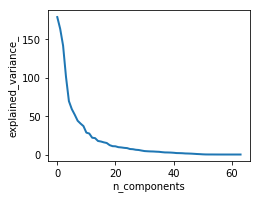

In [29]:
pca.fit(X_digits)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

We can clearly see that ~40 components captures almost all of the variance. This is a good reduction down from the input 64. When we apply this to text `PCA` knocks down the number of columns even more dramatically. Now let's prove that ~40 is the right number using data! Specifically we will let a `GridSearchCV` guide our hyperparamter tuning.

### Set `PCA` Parameters and `SVC` Parameters to be tested using `GridSearchCV`

In [30]:
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

### Init `GridSearchCV` Object

In [31]:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))

### Fit `GridSearchCV` Using `Pipeline`

In [32]:
estimator.fit(digits.data, digits.target)
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/travisjefferies/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/U

### Plot results

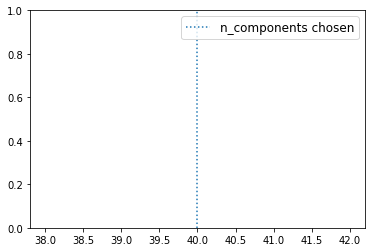

In [33]:
plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

### Fin!